# HomeBrew BeerAnalysis

### Context
This is a dataset of 75,000 homebrewed beers with over 176 different styles. Beer records are user-reported and are classified according to one of the 176 different styles. These recipes go into as much or as little detail as the user provided, but there's at least 5 useful columns where data was entered for each: Original Gravity, Final Gravity, ABV, IBU, and Color

### Inspiration
What goes into homemade beer?

It would be interesting to see if the data provided is enough to define each class or if there are undiscovered patterns. In the future it might be possible to go through and scrape more detailed information for each recipe, such as the yeast and specific hops used.

## Problem Statement

Based on the above, let's attempt to predict beer style.

## Intitial Setup

### Clear Environment

In [1]:
rm(list = ls())

options(repr.plot.width=13, repr.plot.height=10)

## Load Libraries

In [2]:
library(tidyverse)
library(tidymodels)
library(skimr)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 0.1.0 ──

✔ broom     0.5.4     ✔ rsample   0.0.5
✔ dials     0.0.4     ✔ tune      0.0.1
✔ infer     0.5.1     ✔ workflows 0.1.0
✔ parsnip   0.0.5     ✔ yardstick 0.0.5
✔ recipes   0.1.9     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard()   masks purrr::discard()
✖ dplyr::filter()     masks stats::filter()
✖ recipes::fixed()    masks stringr::fixed()
✖ dplyr::lag()        masks stats::lag()
✖ dials::margin()     masks ggplot2::margin()
✖ yardstick::spec()   masks readr::spec()
✖ re

## Read in Data

In [3]:
beer_recipes = read_csv("recipeData.csv")

Parsed with column specification:
cols(
  .default = col_double(),
  Name = col_character(),
  URL = col_character(),
  Style = col_character(),
  BoilGravity = col_character(),
  MashThickness = col_character(),
  SugarScale = col_character(),
  BrewMethod = col_character(),
  PitchRate = col_character(),
  PrimaryTemp = col_character(),
  PrimingMethod = col_character(),
  PrimingAmount = col_character()
)

See spec(...) for full column specifications.



# Intitial View

Let's get a glimpse of what're working with here.

In [43]:
beer_recipes %>% glimpse()

Observations: 73,861
Variables: 23
$ BeerID        <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, …
$ Name          <chr> "Vanilla Cream Ale", "Southern Tier Pumking clone", "Zo…
$ URL           <chr> "/homebrew/recipe/view/1633/vanilla-cream-ale", "/homeb…
$ Style         <chr> "Cream Ale", "Holiday/Winter Special Spiced Beer", "Ame…
$ StyleID       <dbl> 45, 85, 7, 7, 20, 10, 86, 45, 129, 86, 7, 7, 7, 7, 7, 3…
$ `Size(L)`     <dbl> 21.77, 20.82, 18.93, 22.71, 50.00, 24.61, 22.71, 20.82,…
$ OG            <dbl> 1.055, 1.083, 1.063, 1.061, 1.060, 1.055, 1.072, 1.054,…
$ FG            <dbl> 1.013, 1.021, 1.018, 1.017, 1.010, 1.013, 1.018, 1.014,…
$ ABV           <dbl> 5.48, 8.16, 5.91, 5.80, 6.48, 5.58, 7.09, 5.36, 5.77, 8…
$ IBU           <dbl> 17.65, 60.65, 59.25, 54.48, 17.84, 40.12, 268.71, 19.97…
$ Color         <dbl> 4.83, 15.64, 8.98, 8.50, 4.57, 8.00, 6.33, 5.94, 34.76,…
$ BoilSize      <dbl> 28.39, 24.61, 22.71, 26.50, 60.00, 29.34, 30.28, 28.39,…
$ BoilTime      <

Great! I see a few issues in the data that I already know I'm going to have to account for, but I'll go into more detail when I get there.

# Data Cleansing

## Using a Recipe

In R, there is a concept called a **recipe** (nothing to do with the data I'm currently working with lol). It basically allows one to build incremental steps for cleaning/pre-processing the data to get it ready for analysis, modeling, etc. I personally like it because:

1. It will list out the steps that I am performing on the data, and what variables are going to be affected by those steps.

2. It performs lazy evaluation, so it doesn't actually do anything to the data until you ask for it.

So let's start off with initializing our recipe!

At this point I'm going to split our train and test set, our train set will guide us through all of the steps we need to perform in order to get our model ready, and our test set will act as new data that we've never seen before to help assess how well our model did on **real data**.

In [5]:
set.seed(0415)
split = initial_split(beer_recipes)

split

train = training(split)
test = testing(split)

beer_rec = train %>% recipe()

beer_rec

<55396/18465/73861>

Data Recipe

Inputs:

  23 variables (no declared roles)

So ~55,000 training records and ~18,000 testing records.

Some of the first things that stood out to me in the glimpse above are:

1. There are values showing up as "N/A" and not being recognized as **actual NA** values in R.

2. BoilGravity and PrimaryTemp columns are character columns when they should be numeric. This is likely due to the "N/A" issue.

Additionally, there are some standard things I'll take care of:

1. Change all column names to lower case. This is mostly a matter of preference.

2. Change all character columns to factors (categorical). This is to help reduce memory.

In [6]:
beer_rec = beer_rec %>%
    step_rename_at(everything(), fn = ~str_to_lower(.)) %>% # change column names to lowercase
    step_rename(size_l = `size(l)`) %>%
    step_mutate_at(all_nominal(), fn = ~na_if(., "N/A")) %>% # convert "N/A" to NA
    step_mutate_at(boilgravity, primarytemp, fn = ~as.numeric(as.character(.)))

beer_rec

Data Recipe

Inputs:

  23 variables (no declared roles)

Operations:

Variable renaming for everything
Variable renaming for  size_l
Variable mutation for all_nominal
Variable mutation for boilgravity, primarytemp

You can see above that the output of our recipe provides a nice simple way to understand what steps and in what order the recipe intends to perform on our data.

If we wanted to get an idea of what our data would look like as a result of our recipe **so far** we can do that. Just prepare the recipe and juice it!

In [7]:
beer_rec %>% prep() %>% juice() %>% glimpse()

Observations: 55,396
Variables: 23
$ beerid        <dbl> 1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 16, 17, 20, 21, 22…
$ name          <fct> Vanilla Cream Ale, Zombie Dust Clone - EXTRACT, Zombie …
$ url           <fct> /homebrew/recipe/view/1633/vanilla-cream-ale, /homebrew…
$ style         <fct> Cream Ale, American IPA, American IPA, Belgian Blond Al…
$ styleid       <dbl> 45, 7, 7, 20, 10, 86, 45, 7, 7, 7, 7, 31, 134, 7, 65, 8…
$ size_l        <dbl> 21.77, 18.93, 22.71, 50.00, 24.61, 22.71, 20.82, 25.00,…
$ og            <dbl> 1.0550, 1.0630, 1.0610, 1.0600, 1.0550, 1.0720, 1.0540,…
$ fg            <dbl> 1.0130, 1.0180, 1.0170, 1.0100, 1.0130, 1.0180, 1.0140,…
$ abv           <dbl> 5.48, 5.91, 5.80, 6.48, 5.58, 7.09, 5.36, 6.63, 6.62, 7…
$ ibu           <dbl> 17.65, 59.25, 54.48, 17.84, 40.12, 268.71, 19.97, 64.26…
$ color         <dbl> 4.83, 8.98, 8.50, 4.57, 8.00, 6.33, 5.94, 7.78, 14.26, …
$ boilsize      <dbl> 28.39, 22.71, 26.50, 60.00, 29.34, 30.28, 28.39, 29.00,…
$ boiltime      <

There are some columns in here that don't provide any additional value to us since they are essentially id columns, or made redundant by other columns:

1. Beerid is the id of every row

2. Name is going to be mostly unique to every row (this could prove useful to analyze, but for now I'll drop it)

3. URL is just the link to where the recipe lives

4. Styleid is already represented by Style

5. Userid is a variable that could have some value (particular users are more likely to input their favorite beers) but we will disregard it for now

In [8]:
beer_rec = beer_rec %>%
    step_rm(
        beerid,
        name,
        url,
        styleid,
        userid
    ) # remove the variables mentioned above

In [9]:
beer_rec
beer_rec %>% prep() %>% juice() %>% glimpse()

Data Recipe

Inputs:

  23 variables (no declared roles)

Operations:

Variable renaming for everything
Variable renaming for  size_l
Variable mutation for all_nominal
Variable mutation for boilgravity, primarytemp
Delete terms beerid, name, url, styleid, userid

Observations: 55,396
Variables: 18
$ style         <fct> Cream Ale, American IPA, American IPA, Belgian Blond Al…
$ size_l        <dbl> 21.77, 18.93, 22.71, 50.00, 24.61, 22.71, 20.82, 25.00,…
$ og            <dbl> 1.0550, 1.0630, 1.0610, 1.0600, 1.0550, 1.0720, 1.0540,…
$ fg            <dbl> 1.0130, 1.0180, 1.0170, 1.0100, 1.0130, 1.0180, 1.0140,…
$ abv           <dbl> 5.48, 5.91, 5.80, 6.48, 5.58, 7.09, 5.36, 6.63, 6.62, 7…
$ ibu           <dbl> 17.65, 59.25, 54.48, 17.84, 40.12, 268.71, 19.97, 64.26…
$ color         <dbl> 4.83, 8.98, 8.50, 4.57, 8.00, 6.33, 5.94, 7.78, 14.26, …
$ boilsize      <dbl> 28.39, 22.71, 26.50, 60.00, 29.34, 30.28, 28.39, 29.00,…
$ boiltime      <dbl> 75, 60, 60, 90, 70, 90, 75, 90, 90, 60, 60, 60, 60, 60,…
$ boilgravity   <dbl> 1.038, NA, NA, 1.050, 1.047, NA, 1.040, 1.055, NA, NA, …
$ efficiency    <dbl> 70, 70, 70, 72, 79, 75, 70, 74, 70, 70, 30, 75, 70, 70,…
$ mashthickness <fct> NA, NA, NA, NA, NA, NA, 1.4, NA, NA, NA, NA, NA, NA, 1.…
$ sugarscale    <

# Exploration

Now lets get a look at the quality of the data that remains. The skimr package has a function, skim, that provides a nice  30,000 ft view.

In [10]:
beer_skim = beer_rec %>%
    prep() %>%
    juice() %>%
    skim()

In [11]:
beer_skim

── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             55396     
Number of columns          18        
_______________________              
Column type frequency:               
  factor                   7         
  numeric                  11        
________________________             
Group variables            None      

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique
1 style               465        0.992  FALSE        175
2 mashthickness     22380        0.596  FALSE        496
3 sugarscale            0        1      FALSE          2
4 brewmethod            0        1      FALSE          4
5 pitchrate         29239        0.472  FALSE          9
6 primingmethod     50274        0.0925 FALSE        722
7 primingamount     51802        0.0649 FALSE       1559
  top_counts                             

One last cleanup step we can do is removing variables with a lot of missing data. Several variables from above have low completion rates. Lets set a threshold of 60%, meaning we will remove variables with less than 60% completion rates. This is a personal threshold that I initially choose to set. This threshold could very well be adjusted.

In [12]:
vars_remove = beer_skim %>%
    filter(complete_rate < 0.6) %>% # collect variables with less than 60% completion rate
    select(skim_variable) %>%
    .[[1]]

beer_rec = beer_rec %>%
    step_rm(one_of(vars_remove))

In [13]:
beer_rec
beer_rec %>% prep() %>% juice() %>% skim()

Data Recipe

Inputs:

  23 variables (no declared roles)

Operations:

Variable renaming for everything
Variable renaming for  size_l
Variable mutation for all_nominal
Variable mutation for boilgravity, primarytemp
Delete terms beerid, name, url, styleid, userid
Delete terms one_of, vars_remove

── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             55396     
Number of columns          14        
_______________________              
Column type frequency:               
  factor                   3         
  numeric                  11        
________________________             
Group variables            None      

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique
1 style               465         0.992 FALSE        175
2 sugarscale            0         1     FALSE          2
3 brewmethod            0         1     FALSE          4
  top_counts                                 
1 Ame: 8968, Ame: 5677, Sai: 1953, Ame: 1678 
2 Spe: 53976, Pla: 1420                      
3 All: 37264, BIA: 8908, ext: 6522, Par: 2702

── Variable type: numeric ──────────────────────────────────────────────────────
   

Cool, now let's start diving a little deeper into our remaining variables.

## Dependent Variables

Let's take a look at our dependent variable, style, that we intend on predicting.

1. Missing data: while its possible that the values could be missing at random (MAR), maybe its possible that when the recipe was input by the user, the style classification that they intended on using was not available so they left it blank, which is intentional and is the assumption I'm going to use meaning that missing values should be their own classification

2. In the profile above we can see that there are 100+ styles available for us to classify, and the frequency of the top 4 starts off at ~9,000 and quickly drops to the next frequent of 5,600 then to the 2,000s and so on. That's almost 1/3 of the data grouped in the top 4 styles. We could group everything else into an "other" category, so let's choose a threshold that if a style occurs less than 1500 times in our data, that it get's classified as such.

In [14]:
beer_rec = beer_rec %>%
    step_mutate(style = fct_explicit_na(style)) %>% # turn NA values into their own classification
    step_other(style, threshold = 1500) # group classes appearing less than 2000 times into an "other" group

In [15]:
beer_rec
beer_rec %>% prep() %>% juice() %>% count(style) # count the frequency of remaining styles

Data Recipe

Inputs:

  23 variables (no declared roles)

Operations:

Variable renaming for everything
Variable renaming for  size_l
Variable mutation for all_nominal
Variable mutation for boilgravity, primarytemp
Delete terms beerid, name, url, styleid, userid
Delete terms one_of, vars_remove
Variable mutation for  style
Collapsing factor levels for style

style,n
<fct>,<int>
American Amber Ale,1532
American IPA,8968
American Light Lager,1678
American Pale Ale,5677
Saison,1953
other,35588


Nice, now the problem is that because we have so many styles with less than 1500 entries, all of them pooled together is still an overwhelimg amount. This causes a class imbalance, so essentially our model (depending on the one used) could become bias to choosing **other** since it's learned on more data that is classified as **other** compared to the alternate available labels. One trick to accomodate for this is to downsample our data so that we end up with relatively similar amounts of rows for each style, i.e giving all classes an equal opportunity to be learned by the model.

In [16]:
beer_rec = beer_rec %>%
    step_downsample(style)

In [17]:
beer_rec
beer_rec  %>% prep() %>% juice() %>% count(style)

Data Recipe

Inputs:

  23 variables (no declared roles)

Operations:

Variable renaming for everything
Variable renaming for  size_l
Variable mutation for all_nominal
Variable mutation for boilgravity, primarytemp
Delete terms beerid, name, url, styleid, userid
Delete terms one_of, vars_remove
Variable mutation for  style
Collapsing factor levels for style
Down-sampling based on style

style,n
<fct>,<int>
American Amber Ale,1532
American IPA,1532
American Light Lager,1532
American Pale Ale,1532
Saison,1532
other,1532


Even Steven!

## Independent Variables

Looking at our most recent profiling (skim) of the data above, we still have some missing data for both boilgravity and primarytemp. These measurements seem to actually be missing at random; both appear to be measurements that are taken at particular times in the brewing process and could have easily been missed. With this info, we know we will have to impute these variables

In [18]:
beer_rec = beer_rec %>%
    step_bagimpute(boilgravity, primarytemp)

Now let's take a look at the distributions of our variables, as well as what they look like against each other.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better valu

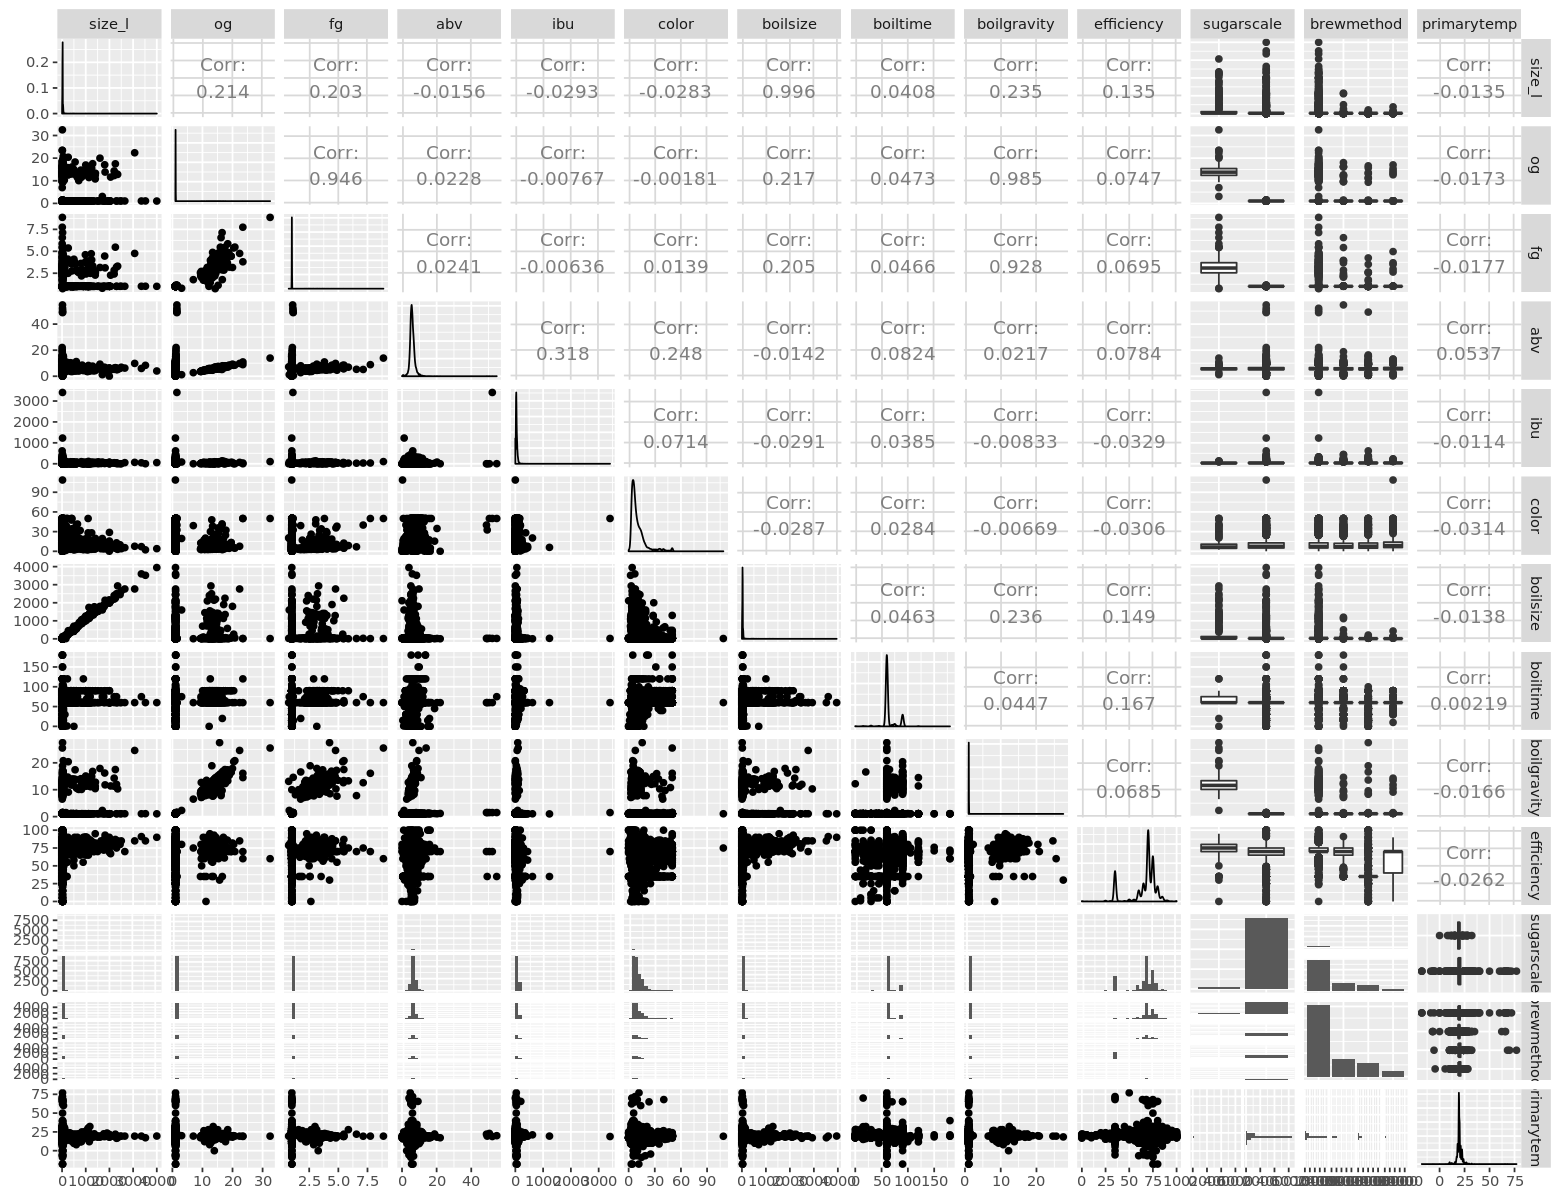

In [19]:
beer_rec %>%
    prep() %>%
    juice() %>%
    select(-style) %>%
    ggpairs()

I know this plot is a little bit messy, but just to point out a few things I notice... Looking at the variables individually, there appears to be some skew amongst all of them, so we can adjust this with a transformation like BoxCox or YeoJohnson.

Regarding the categorical vars, sugarscale is heavily imbalanced.
- I learned that brewers can define the specific gravity of the beer, but some like to use what is known as the "Plato" scale. Since we are here, lets take this opportunity to convert gravity measurements with Plato values to Specifc Gravity. SG = (4P/1000) + 1

In [20]:
beer_rec = beer_rec %>%
    step_YeoJohnson(all_numeric()) %>% # remove some skew from skewed vars
    step_mutate_at(fg, og, boilgravity, fn = ~((4 * .)/1000) + 1) %>% # convert final gravity using plato values to specific gravity
    step_rm(sugarscale) # remove sugarscale column because now specific gravity is the only value    

In [21]:
beer_rec
beer_rec %>% prep() %>% juice() %>% glimpse()

Data Recipe

Inputs:

  23 variables (no declared roles)

Operations:

Variable renaming for everything
Variable renaming for  size_l
Variable mutation for all_nominal
Variable mutation for boilgravity, primarytemp
Delete terms beerid, name, url, styleid, userid
Delete terms one_of, vars_remove
Variable mutation for  style
Collapsing factor levels for style
Down-sampling based on style
Bagged tree imputation for boilgravity, primarytemp
Yeo-Johnson transformation on all_numeric
Variable mutation for fg, og, boilgravity
Delete terms sugarscale

Observations: 9,192
Variables: 13
$ style       <fct> American Amber Ale, American Amber Ale, American Amber Al…
$ size_l      <dbl> 1.775784, 1.803888, 1.803888, 1.886012, 1.855547, 1.82880…
$ og          <dbl> 1.004300, 1.004240, 1.004240, 1.004220, 1.004260, 1.00426…
$ fg          <dbl> 1.004036, 1.004064, 1.004068, 1.004048, 1.004060, 1.00406…
$ abv         <dbl> 2.850152, 2.453214, 2.433714, 2.479746, 2.661498, 2.66591…
$ ibu         <dbl> 0.000000, 5.781126, 7.438330, 9.561051, 11.584073, 10.097…
$ color       <dbl> 1.669649, 2.202502, 1.691027, 2.022844, 1.962021, 1.98490…
$ boilsize    <dbl> 1.898764, 1.955817, 1.661273, 1.961717, 1.971877, 2.00135…
$ boiltime    <dbl> 72.25711, 49.32056, 41.53138, 25.63932, 72.25711, 49.3205…
$ boilgravity <dbl> 1.004210, 1.004180, 1.004210, 1.004220, 1.004224, 1.00418…
$ efficiency  <dbl> 178237.01, 220129.90, 13632.68, 220129.90, 211268.70, 194…
$ brewmethod  <fct> All Grain, All Grain, extract, BIAB, All Grain, All Grain…
$ primarytemp <dbl

We now have one categorical independent variable left, brewmethod. Depending on the type of modelling technique we use, this variable would have to be dummy/one-hot encoded. A model like KNN would require this, but a random forest would not. It shouldn't hurt though, and since I intend on trying KNN, lets one-hot encode it.

In [22]:
beer_rec = beer_rec %>%
    step_dummy(all_nominal(), -style, one_hot = TRUE)

In [23]:
beer_rec %>% prep() %>% juice() %>% glimpse()

Observations: 9,192
Variables: 16
$ style                   <fct> American Amber Ale, American Amber Ale, Ameri…
$ size_l                  <dbl> 1.775784, 1.803888, 1.803888, 1.886012, 1.855…
$ og                      <dbl> 1.004300, 1.004240, 1.004240, 1.004220, 1.004…
$ fg                      <dbl> 1.004036, 1.004064, 1.004068, 1.004048, 1.004…
$ abv                     <dbl> 2.850152, 2.453214, 2.433714, 2.479746, 2.661…
$ ibu                     <dbl> 0.000000, 5.781126, 7.438330, 9.561051, 11.58…
$ color                   <dbl> 1.669649, 2.202502, 1.691027, 2.022844, 1.962…
$ boilsize                <dbl> 1.898764, 1.955817, 1.661273, 1.961717, 1.971…
$ boiltime                <dbl> 72.25711, 49.32056, 41.53138, 25.63932, 72.25…
$ boilgravity             <dbl> 1.004210, 1.004180, 1.004210, 1.004220, 1.004…
$ efficiency              <dbl> 178237.01, 220129.90, 13632.68, 220129.90, 21…
$ primarytemp             <dbl> 18.67447, 19.22292, 18.68587, 17.32834, 17.32…
$ brewmethod_All.G

Coming into some of the final pre-processing steps we can utilize, lets see if any of our remaining independent variables have any **Near-Zero Variance**. These sparse & highly imbalanced IVs have low predictive power due to their lack of variation/occurrence relative to the different styles that occur, so let's filter them out.

In [24]:
beer_rec = beer_rec %>%
    step_nzv(all_numeric())

In [25]:
beer_rec %>% prep() %>% juice() %>% glimpse()

Observations: 9,192
Variables: 15
$ style                <fct> American Amber Ale, American Amber Ale, American…
$ size_l               <dbl> 1.775784, 1.803888, 1.803888, 1.886012, 1.855547…
$ og                   <dbl> 1.004300, 1.004240, 1.004240, 1.004220, 1.004260…
$ fg                   <dbl> 1.004036, 1.004064, 1.004068, 1.004048, 1.004060…
$ abv                  <dbl> 2.850152, 2.453214, 2.433714, 2.479746, 2.661498…
$ ibu                  <dbl> 0.000000, 5.781126, 7.438330, 9.561051, 11.58407…
$ color                <dbl> 1.669649, 2.202502, 1.691027, 2.022844, 1.962021…
$ boilsize             <dbl> 1.898764, 1.955817, 1.661273, 1.961717, 1.971877…
$ boiltime             <dbl> 72.25711, 49.32056, 41.53138, 25.63932, 72.25711…
$ boilgravity          <dbl> 1.004210, 1.004180, 1.004210, 1.004220, 1.004224…
$ efficiency           <dbl> 178237.01, 220129.90, 13632.68, 220129.90, 21126…
$ primarytemp          <dbl> 18.67447, 19.22292, 18.68587, 17.32834, 17.32834…
$ brewmethod_All.G

Next lets see if any issues of high correlation are present.

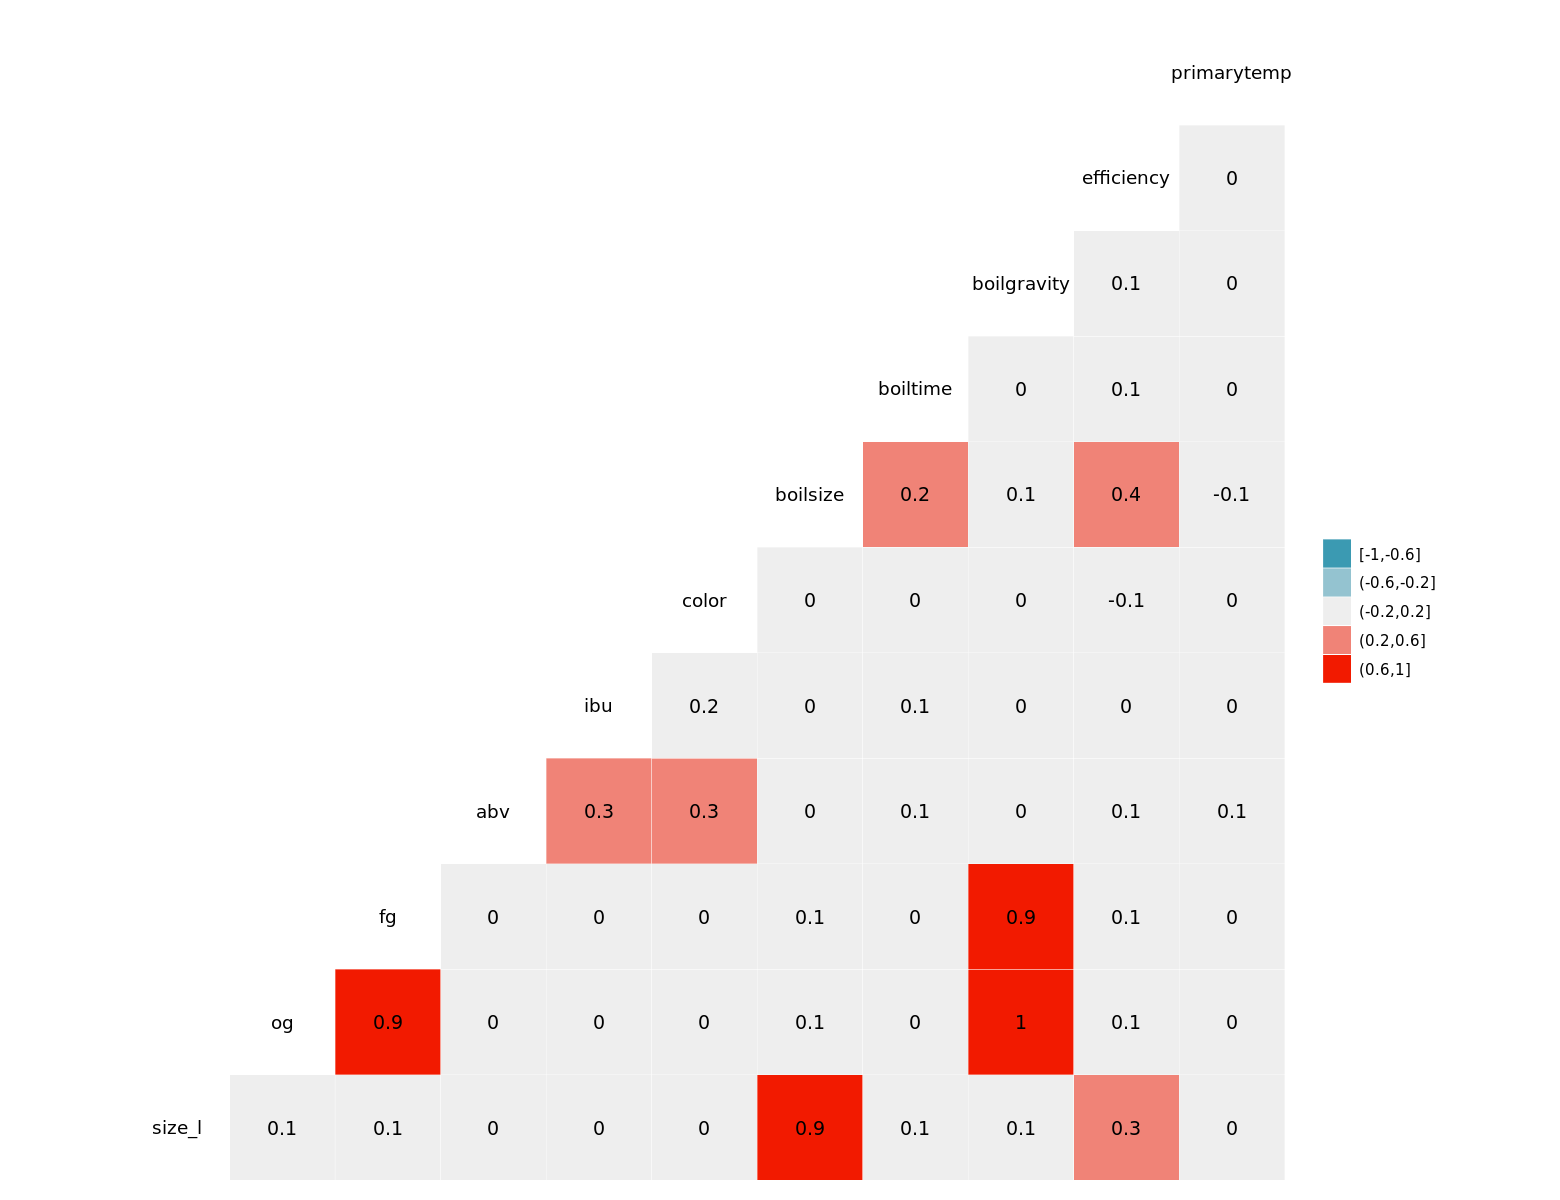

In [26]:
beer_rec %>%
    prep() %>%
    juice() %>%
    select_if(is.numeric) %>%
    select_at(vars(-starts_with("brewmethod"))) %>%
    ggcorr(nbreaks = 5, label = TRUE) # look to see potential multicollinearity

Clearly we have some high correlations amongst a few variables:

- boilgravity vs fg
- boilgravity vs og
- boilsize vs size_l
- fg vs og

Now we can implement a filter to remove highly correlated variables, which would imply that the variables may be redundant of each other. Additionally, after removing highly correlated variables, let's also remove any variables that may be linear combinations of each other, implying a potential issue with multicollinearity.

In [27]:
beer_rec = beer_rec %>%
    step_corr(all_numeric(), threshold = 0.8) %>%
    step_lincomb(all_numeric())

Lastly, because several of our continuous numerical variables live within different scales of each other, let's normalize them all to bring them within the same space.

In [28]:
beer_rec = beer_rec %>%
    step_normalize(all_numeric(), -starts_with("brewmethod"))

In [29]:
beer_rec %>% prep() %>% juice() %>% glimpse()

Observations: 9,192
Variables: 12
$ style                <fct> American Amber Ale, American Amber Ale, American…
$ size_l               <dbl> -0.20380362, -0.05002251, -0.05002251, 0.3993566…
$ fg                   <dbl> -0.1531746, -0.1348155, -0.1321928, -0.1453064, …
$ abv                  <dbl> 1.02733267, -0.06087288, -0.11433241, 0.01186519…
$ ibu                  <dbl> -2.27735546, -0.73114821, -0.28791631, 0.2798221…
$ color                <dbl> 0.105442916, 1.797271835, 0.173318912, 1.2268501…
$ boiltime             <dbl> 2.000994, -0.296342, -1.076510, -2.668266, 2.000…
$ efficiency           <dbl> 0.1164106, 0.6481222, -1.9727751, 0.6481222, 0.5…
$ primarytemp          <dbl> -0.12042289, 0.05232143, -0.11683074, -0.5444035…
$ brewmethod_All.Grain <dbl> 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, …
$ brewmethod_BIAB      <dbl> 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, …
$ brewmethod_extract   <dbl> 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …


Let's get one last look at our final recipe.

In [30]:
beer_rec %>% prep()

Data Recipe

Inputs:

  23 variables (no declared roles)

Training data contained 55396 data points and 37817 incomplete rows. 

Operations:

Variable renaming for BeerID, Name, URL, Style, StyleID, ... [trained]
Variable renaming for  size_l [trained]
Variable mutation for name, url, style, ... [trained]
Variable mutation for boilgravity, primarytemp [trained]
Variables removed beerid, name, url, styleid, userid [trained]
Variables removed mashthickness, pitchrate, primingmethod, primingamount [trained]
Variable mutation for  style [trained]
Collapsing factor levels for style [trained]
Down-sampling based on style [trained]
Bagged tree imputation for boilgravity, primarytemp [trained]
Yeo-Johnson transformation on size_l, abv, ibu, color, ... [trained]
Variable mutation for fg, og, boilgravity [trained]
Variables removed sugarscale [trained]
Dummy variables from brewmethod [trained]
Sparse, unbalanced variable filter removed brewmethod_Partial.Mash [trained]
Correlation filter removed

# Modeling

Let's bake our recipe into our test data. Remember, our test data hasn't seen any of these steps since we are treating it as brand new data.

In [31]:
test_data = beer_rec %>%
    prep() %>%
    bake(test)

Let's try out several different models:

- K Nearest Neighbours (KNN)
- Decision Tree
- Random Forest
- XGBoost

In [32]:
train_data = beer_rec %>% prep() %>% juice()

set.seed(0415)

knn = nearest_neighbor() %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_fit = knn %>%
    fit(style ~ ., train_data)

set.seed(0415)

dectree = decision_tree() %>%
    set_engine("rpart") %>%
    set_mode("classification")

dectree_fit = dectree %>%
    fit(style ~ ., train_data)

# Ensembles
set.seed(0415)

rf = rand_forest() %>%
    set_engine("randomForest") %>%
    set_mode("classification")

rf_fit = rf %>%
    fit(style ~ ., train_data)

set.seed(0415)

xgb = boost_tree() %>%
    set_engine("xgboost") %>%
    set_mode("classification")

xgb_fit = xgb %>%
    fit(style ~ ., train_data)

In [33]:
knn_fit
dectree_fit
rf_fit
xgb_fit

parsnip model object

Fit time:  3.3s 

Call:
kknn::train.kknn(formula = formula, data = data, ks = 5)

Type of response variable: nominal
Minimal misclassification: 0.5039164
Best kernel: optimal
Best k: 5

parsnip model object

Fit time:  533ms 
n= 9192 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 9192 7660 American Amber Ale (0.17 0.17 0.17 0.17 0.17 0.17)  
   2) primarytemp< 0.7528845 8089 6593 American IPA (0.18 0.18 0.18 0.18 0.083 0.18)  
     4) color>=0.4493611 2859 1625 American Amber Ale (0.43 0.084 0.14 0.053 0.021 0.27)  
       8) color< 1.398371 2125  961 American Amber Ale (0.55 0.095 0.096 0.066 0.021 0.17) *
       9) color>=1.398371 734  327 other (0.095 0.054 0.26 0.014 0.022 0.55) *
     5) color< 0.4493611 5230 3891 American Pale Ale (0.048 0.24 0.21 0.26 0.12 0.13)  
      10) ibu>=0.5376232 1459  569 American IPA (0.027 0.61 0.12 0.15 0.019 0.071) *
      11) ibu< 0.5376232 3771 2658 American Pale Ale (0.056 0.097 0.24 0.3 0.15 0.16)  
        22) ibu< -0.612908 932  426 American Light Lager (0.033 0.05 0.54 0.064 0.068 0.24) *
        23) ibu>=-0.612908 2839 1786 American Pale Ale (0.064 0.11 0.14 0.37 0.18 0.13)  
          46) p

parsnip model object

Fit time:  17.2s 

Call:
 randomForest(x = as.data.frame(x), y = y) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 30.36%
Confusion matrix:
                     American Amber Ale American IPA American Light Lager
American Amber Ale                 1151           83                   23
American IPA                         97         1073                   29
American Light Lager                 64           91                 1040
American Pale Ale                   138          242                   49
Saison                               48           55                   25
other                               166           94                  123
                     American Pale Ale Saison other class.error
American Amber Ale                 123     48   104   0.2486945
American IPA                       213     56    64   0.2996084
A

parsnip model object

Fit time:  1.6s 
##### xgb.Booster
raw: 295.8 Kb 
call:
  xgboost::xgb.train(params = list(eta = 0.3, max_depth = 6, gamma = 0, 
    colsample_bytree = 1, min_child_weight = 1, subsample = 1), 
    data = x, nrounds = 15, verbose = 0, objective = "multi:softprob", 
    num_class = 6L, nthread = 1)
params (as set within xgb.train):
  eta = "0.3", max_depth = "6", gamma = "0", colsample_bytree = "1", min_child_weight = "1", subsample = "1", objective = "multi:softprob", num_class = "6", nthread = "1", silent = "1"
xgb.attributes:
  niter
# of features: 11 
niter: 15
nfeatures : 11 

# Evaluating model

So we've trained our models. However, we can potentially improve their predictabilities using **Cross-Fold Validation**. The idea here is to give the models different looks of the data by creating multiple data sets that are essentially different subsets of the original training data. We then train the data on all of these new sets, evaluate the performance and select the model based on a particular criteria.

In [34]:
folds = vfold_cv(train_data, strata = style)
glimpse(folds)

Observations: 10
Variables: 2
$ splits <named list> [<rsplit[8268 x 924 x 9192 x 12]>, <rsplit[8268 x 924 x…
$ id     <chr> "Fold01", "Fold02", "Fold03", "Fold04", "Fold05", "Fold06", "F…


In [35]:
knn_res = fit_resamples(
    style ~ .,
    knn,
    folds,
    control = control_resamples(save_pred = TRUE)
)

dectree_res = fit_resamples(
    style ~ .,
    dectree,
    folds,
    control = control_resamples(save_pred = TRUE)
)

rf_res = fit_resamples(
    style ~ .,
    rf,
    folds,
    control = control_resamples(save_pred = TRUE)
)

xgb_res = fit_resamples(
    style ~ .,
    xgb,
    folds,
    control = control_resamples(save_pred = TRUE)
)

In [36]:
knn_res %>%
    collect_metrics() %>%
    mutate(model = "knn") %>%
    bind_rows(
        dectree_res %>%
            collect_metrics() %>%
            mutate(model = "dectree")
    ) %>%
    bind_rows(
        rf_res %>%
            collect_metrics() %>%
            mutate(model = "rf")
    ) %>%
    bind_rows(
        xgb_res %>%
            collect_metrics() %>%
            mutate(model = "xgb")
    ) %>%
    arrange(.metric, desc(mean))

.metric,.estimator,mean,n,std_err,model
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,multiclass,0.7089834,10,0.005538325,xgb
accuracy,multiclass,0.6969004,10,0.005536357,rf
accuracy,multiclass,0.5440306,10,0.006265448,dectree
accuracy,multiclass,0.4919383,10,0.003866652,knn
roc_auc,hand_till,0.9262713,10,0.002184205,xgb
roc_auc,hand_till,0.9140980,10,0.002991242,rf
roc_auc,hand_till,0.7923928,10,0.003745520,knn
roc_auc,hand_till,0.7904161,10,0.004375007,dectree


We see that XGBoost outperformed the others, barely beating out random forest. Let's visualize the ROC curve of all.

Also, let's see the confusion matrix for our winner.

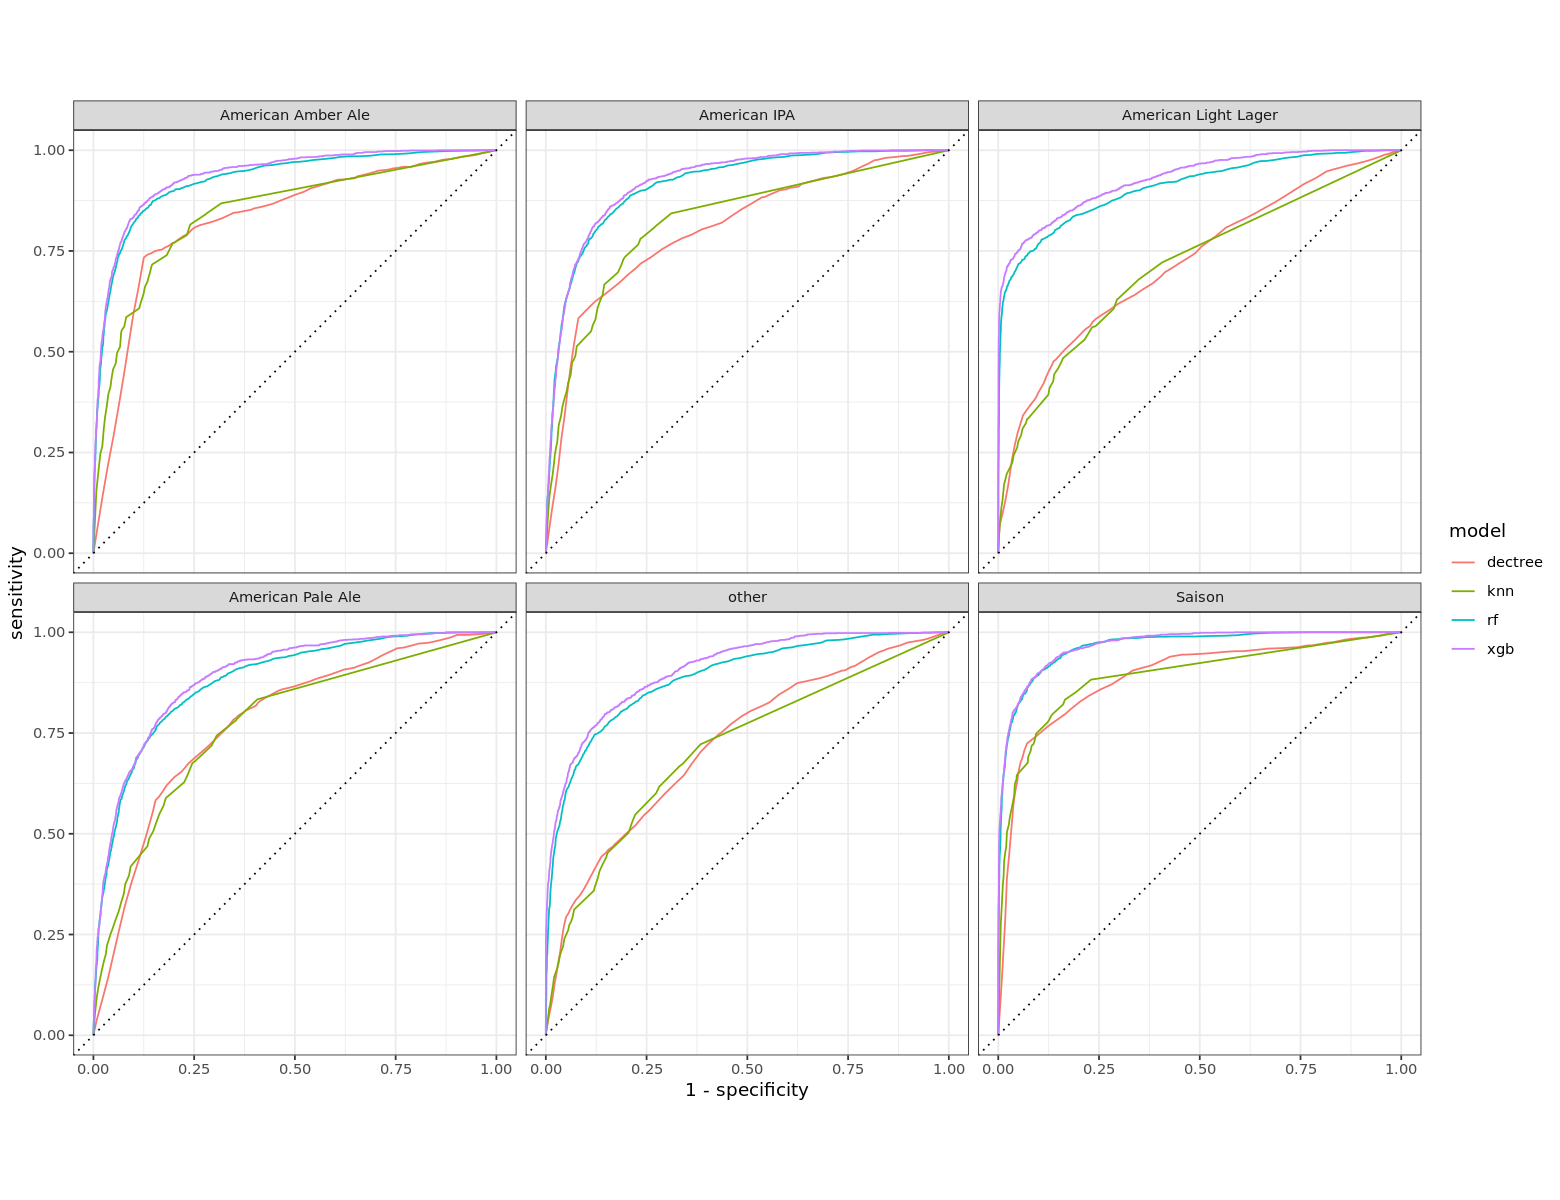

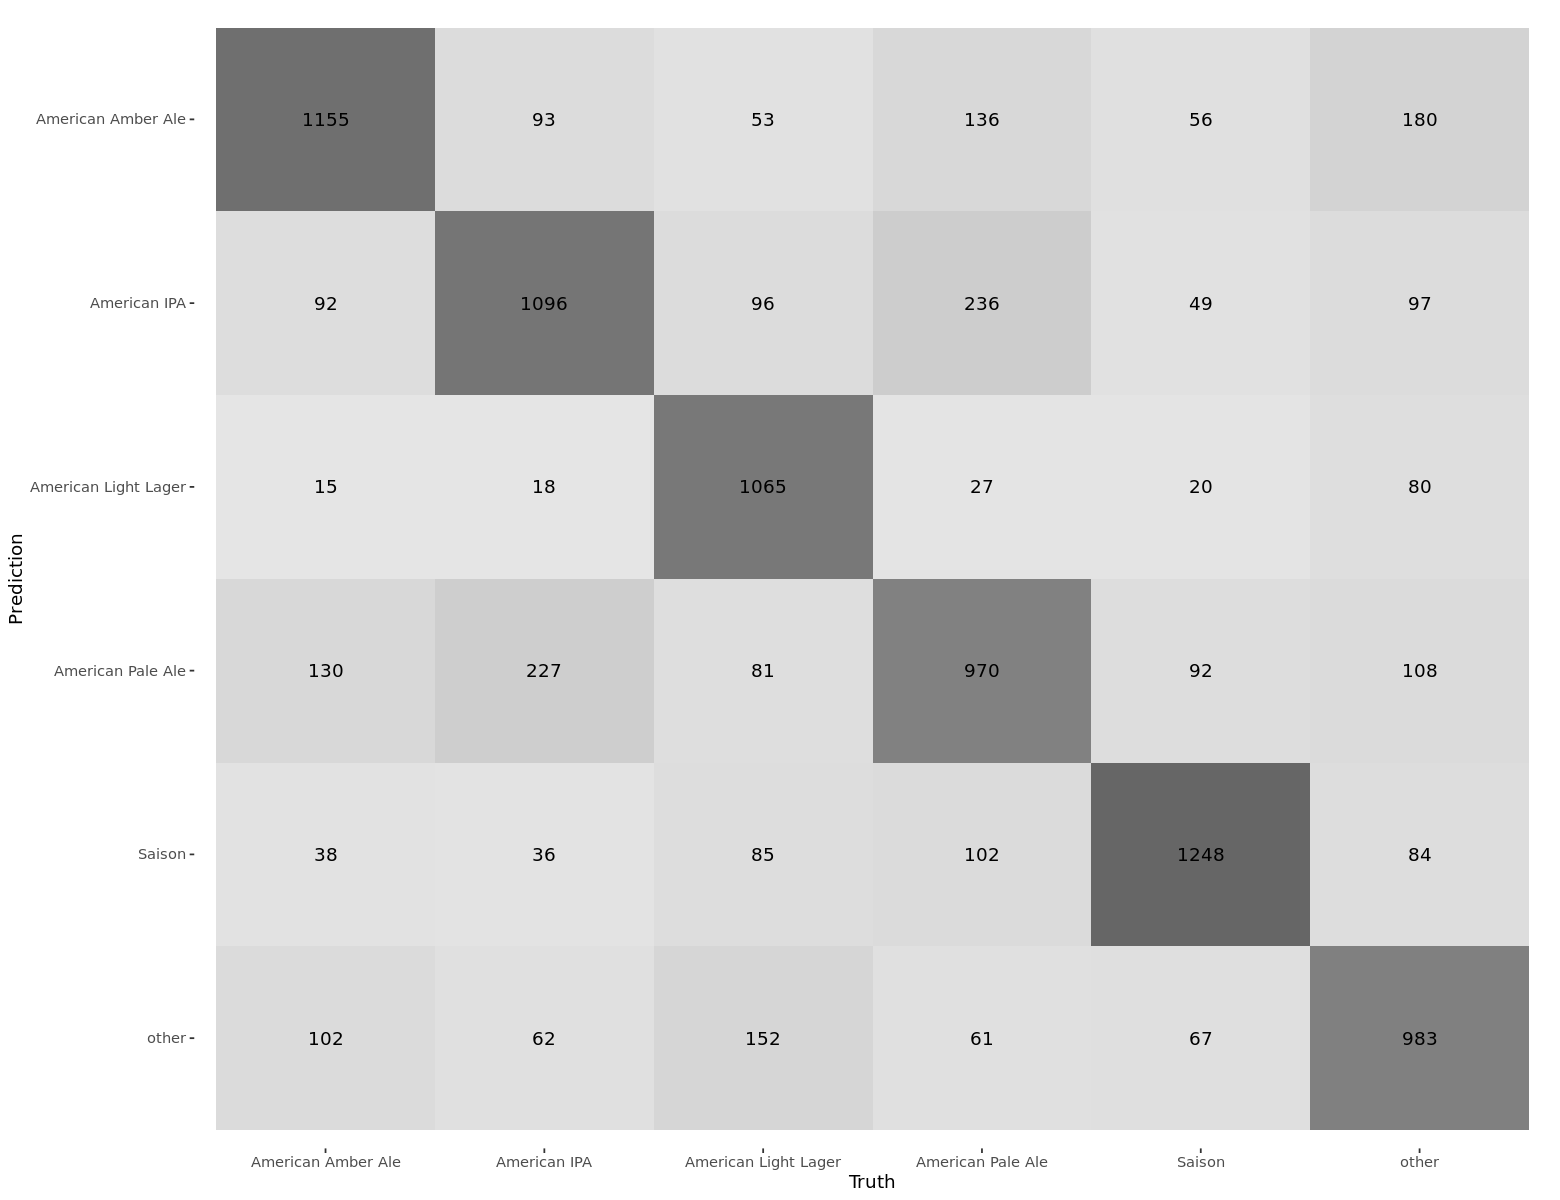

In [37]:
knn_res %>%
    unnest(.predictions) %>%
    mutate(model = "knn") %>%
    bind_rows(
        dectree_res %>%
            unnest(.predictions) %>%
            mutate(model = "dectree")
    ) %>%
    bind_rows(
        rf_res %>%
            unnest(.predictions) %>%
            mutate(model = "rf")
    ) %>%
    bind_rows(
        xgb_res %>%
            unnest(.predictions) %>%
            mutate(model = "xgb")
    ) %>%
    group_by(model) %>%
    roc_curve(starts_with(".pred_"), -.pred_class, truth = style) %>%
    autoplot()

# Confusion Matrix for XGBoost
xgb_res %>%
    unnest(.predictions) %>%
    conf_mat(style, .pred_class) %>%
    autoplot(type = "heatmap")

Now, we will test XGBoost against our **test** data to see how well it performs on unseen data!

In [38]:
class_metrics = metric_set(accuracy)

xgb_fit %>%
    predict(new_data = test_data) %>%
    class_metrics(truth = test_data$style, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6631465


66% of the new styles were correctly classified. That's ok. Not as good as we performed on the training data, but not too far away either.

Some possible areas of improvement:
1. Investigating if there is any value that could be pulled out of the name of the beer.
2. Adjusting the **missing data threshold** for removing variables.
3. Analyzing the imputation methods deeper.
4. Adjusting the style groupings to include more/less classes
5. Hyperparameter Tuning?
6. Trying out other models.

There are many other things that could potentially be improved, but these are just to note a few. Maybe I have some new blog posts now :).

Thanks,